### Test case LVV-T74: Verify implementation of Template Coadds

Verify that the DMS can produce Template Coadds for DIA processing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.geom as geom
from lsst.pipe.tasks.registerImage import RegisterConfig, RegisterTask

In [2]:
butler = Butler('/repo/dp1', collections="LSSTComCam/DP1")

#### Display and inspect images

Select a single `template_coadd` image in each band. Specify only a patch number and band, and limit the query results to return only one dataset reference.

In [3]:
template_refs_dict = {}
bands_list = ['u', 'g', 'r', 'i', 'z', 'y']
for band in bands_list:
    template_refs_dict[band] = butler.query_datasets('template_coadd', band=band,
                                                     patch=5, skymap='lsst_cells_v1', limit=1)

In [4]:
template_refs_dict

{'u': [DatasetRef(DatasetType('template_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'u', skymap: 'lsst_cells_v1', tract: 2394, patch: 5}, run='LSSTComCam/runs/DRP/DP1/DM-51335', id=eebca37e-52cd-49f7-91ef-33e899366bc0)],
 'g': [DatasetRef(DatasetType('template_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'g', skymap: 'lsst_cells_v1', tract: 2394, patch: 5}, run='LSSTComCam/runs/DRP/DP1/DM-51335', id=bf26176e-3b81-4009-a0fc-c1842e14a120)],
 'r': [DatasetRef(DatasetType('template_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'r', skymap: 'lsst_cells_v1', tract: 2394, patch: 5}, run='LSSTComCam/runs/DRP/DP1/DM-51335', id=e9c5d450-6786-4d96-becb-dad588ea87b4)],
 'i': [DatasetRef(DatasetType('template_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'i', skymap: 'lsst_cells_v1', tract: 2394, patch: 5}, run='LSSTComCam/runs/DRP/DP1/DM-51335', id=cfaaa92e-ba1f-42ad-930e-1679a6583397)],
 'z': [DatasetRef(DatasetType('template_coadd', {band, skymap, t

#### Display the ugrizy images

In [5]:
afwDisplay.setDefaultBackend('matplotlib')

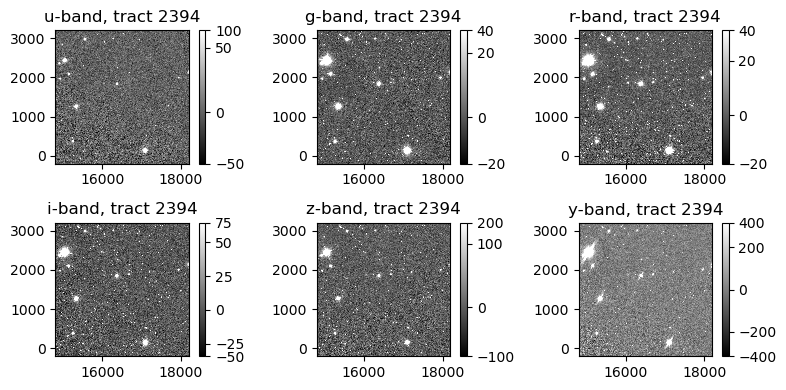

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(8, 4))

for i, band in enumerate(bands_list):
    img = butler.get(template_refs_dict[band][0])
    if i<=2:
        fig.sca(axs[0, i])
    else:
        fig.sca(axs[1, i-3])
    display0 = afwDisplay.Display(frame=fig)
    display0.scale('linear', 'zscale')
    display0.mtv(img.image)
    plt.title(f"{band}-band, tract {template_refs_dict[band][0].dataId['tract']}")

plt.tight_layout()
plt.show()

#### Extract the list of inputs to a `template_coadd`

Compare the number of template inputs to that of the `deep_coadd` for the same dataId.

In [7]:
template_inputs = butler.get('template_coadd', dataId=template_refs_dict['i'][0].dataId).info.getCoaddInputs().ccds.asAstropy()
deepcoadd_inputs = butler.get('deep_coadd', dataId=template_refs_dict['i'][0].dataId).info.getCoaddInputs().ccds.asAstropy()

In [8]:
print(len(template_inputs), len(deepcoadd_inputs))

25 75


We see that, as expected, the template uses 1/3 of the visits that went into the deep coadd.

Confirm that the images going into the template are the 1/3 of images with the best seeing.

In [9]:
ccdvis = butler.get('visit_detector_table')

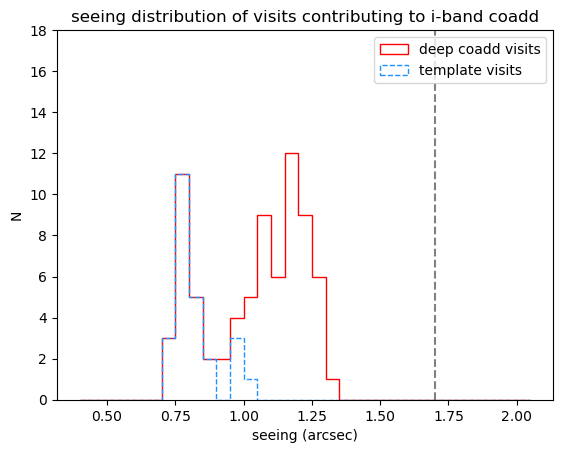

In [10]:
seeing_vals = []
deepcoadd_seeing_vals = []

for inp in template_inputs:
    pick_vis = (ccdvis['visitId'] == inp['visit']) & (ccdvis['detectorId'] == inp['ccd'])
    seeing_vals.append(ccdvis['seeing'][pick_vis].value[0])

for inp in deepcoadd_inputs:
    pick_vis = (ccdvis['visitId'] == inp['visit']) & (ccdvis['detectorId'] == inp['ccd'])
    deepcoadd_seeing_vals.append(ccdvis['seeing'][pick_vis].value[0])

plt.hist(deepcoadd_seeing_vals, bins=np.arange(0.4, 2.1, 0.05), histtype='step', color='Red',
         linestyle='-', label='deep coadd visits')
plt.hist(seeing_vals, bins=np.arange(0.4, 2.1, 0.05), histtype='step', color='DodgerBlue',
         linestyle='--', label='template visits')
plt.legend()
plt.vlines(1.7, 0, 18, linestyle='--', color='Gray')
plt.ylim(0, 18)
plt.xlabel('seeing (arcsec)')
plt.ylabel('N')
plt.title('seeing distribution of visits contributing to i-band coadd')
plt.show()

The threshold for inclusion in coadds is PSF FWHM < 1.7 arcsec. This value is highlighted by the dashed line in the figure above; we see that all of the visits meet this selection criterion for the deep coadd.

The template visits occupy the lowest-seeing bins, as expected.

#### Compare visit, template, and difference images

The visit and difference images need to be registered (or "warped") to the same sky orientation as the template coadd. We define a function to do this, then display the images side-by-side.

In [11]:
def warp_img(ref_img, img_to_warp, ref_wcs, wcs_to_warp):

    config = RegisterConfig()
    task = RegisterTask(name="register", config=config)
    warpedExp = task.warpExposure(img_to_warp, wcs_to_warp, ref_wcs,
                                  ref_img.getBBox())

    return warpedExp

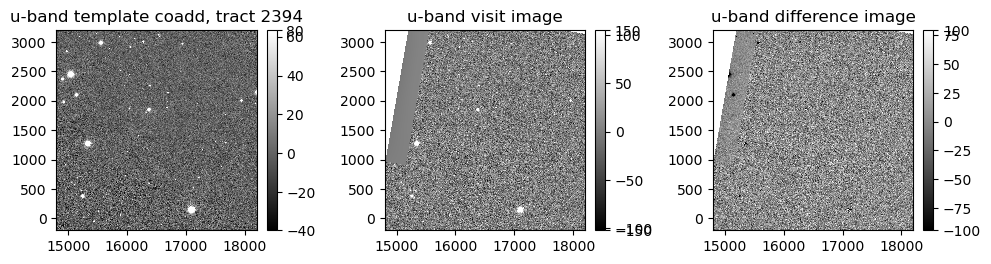

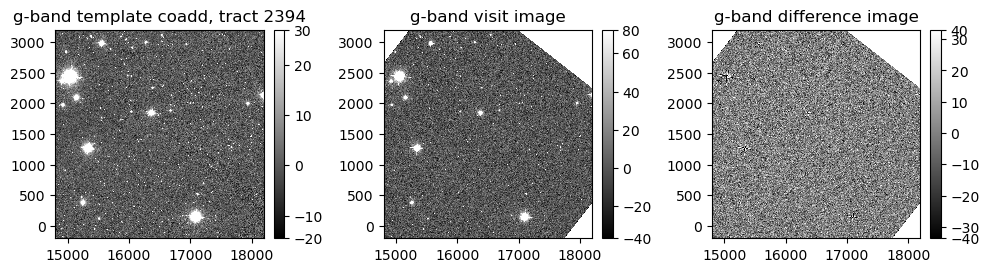

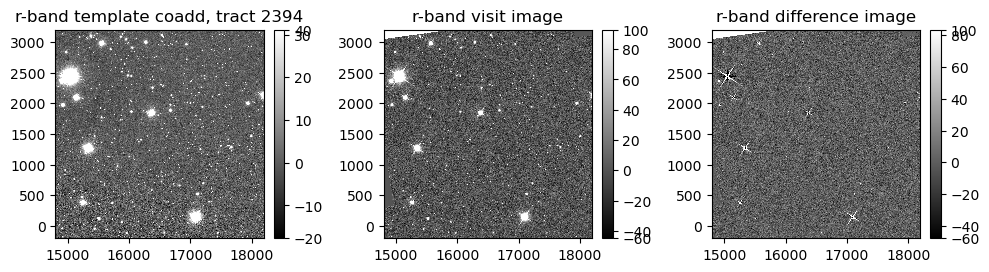

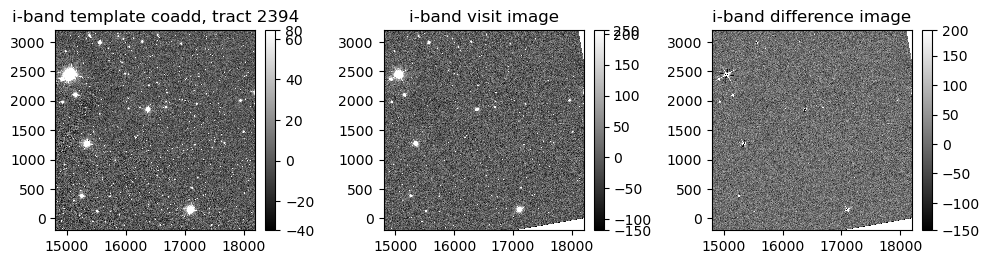

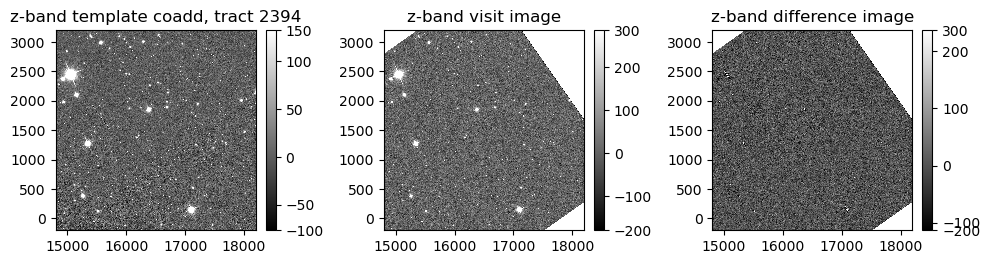

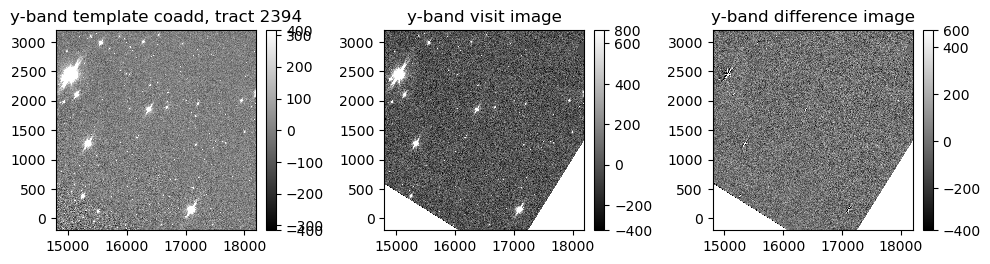

In [12]:
for i, band in enumerate(bands_list):
    img = butler.get(template_refs_dict[band][0])
    inputs = img.info.getCoaddInputs().ccds.asAstropy()
    index = np.argmax(inputs['goodpix'])
    visim = butler.get('visit_image', visit=inputs['visit'][index], detector=inputs['ccd'][index])
    diffim = butler.get('difference_image', visit=inputs['visit'][index], detector=inputs['ccd'][index])
    img_warped = warp_img(img, visim, img.getWcs(), visim.getWcs())
    diff_img_warped = warp_img(img, diffim, img.getWcs(), diffim.getWcs())

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    fig.sca(axs[0])
    display0 = afwDisplay.Display(frame=fig)
    display0.scale('linear', 'zscale')
    display0.mtv(img.image)
    plt.title(f"{band}-band template coadd, tract {template_refs_dict[band][0].dataId['tract']}")

    fig.sca(axs[1])
    display1 = afwDisplay.Display(frame=fig)
    display1.scale('linear', 'zscale')
    display1.mtv(img_warped.image)
    plt.title(f"{band}-band visit image")

    fig.sca(axs[2])
    display1 = afwDisplay.Display(frame=fig)
    display1.scale('linear', 'zscale')
    display1.mtv(diff_img_warped.image)
    plt.title(f"{band}-band difference image")

    plt.tight_layout()
    plt.show()

One can visually see that the `template_coadd` images are deeper than the single-visit images.

#### Configuration

Examine the configuration that was used for the tasks to select visits and assemble them into a template coadd.

In [13]:
cfg = butler.get('selectTemplateCoaddVisits_config', dataId=template_refs_dict['i'][0].dataId)
cfg

lsst.pipe.tasks.selectImages.BestSeeingQuantileSelectVisitsConfig(saveLogOutput=True, qMin=0.0, qMax=0.33, nVisitsMin=12, doConfirmOverlap=True, connections={'skyMap': 'skyMap', 'visitSummaries': 'visit_summary', 'goodVisits': 'template_coadd_visit_selection', 'coaddName': 'goodSeeing', 'calexpType': ''})

We see that image quality cuts were applied in the selection of template coadd inputs. In particular, thresholds were applied to select the 1/3 of the images with best seeing (qMax=0.33), and to require at least 12 visits for templates (nVisitMin=12).

## Results

We have demonstrated that the DM pipelines are producing template coadd images, and examined their properties and associated data products and metadata. The result of this test is a **Pass**.